In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib import cm
from tqdm import tqdm
import time
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path
from scipy.spatial.distance import cdist
from numba import njit, prange
import numba

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
import stumpy  # local load

## Load dataset
https://archive.ics.uci.edu/ml/machine-learning-databases/00302/

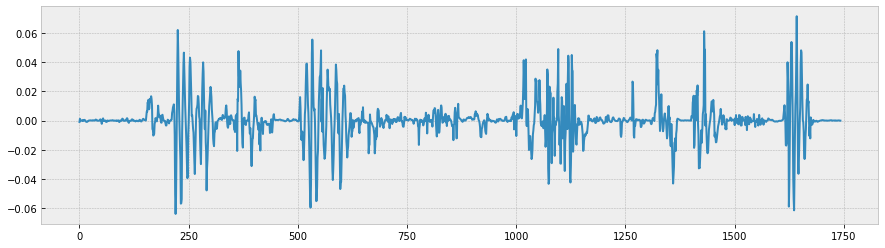

In [2]:
dfx = pd.read_csv("a1_va3.pkl")
v = dfx.values[:, 1]
plt.figure(figsize=(15, 4))
plt.plot(v)
plt.show()

## DTW MP
- As structure, two different dtw can be supported.
- Add pruned feature to exstract meaningfull area for dtw calculation, and   
it reduces the bottleneck of DTWMP calculation cost. 

In [3]:
@njit(
    # "(f8[:], f8[:], f8[:, :])",
    fastmath=True
)
def _dtw(s1, s2, mask):
    l1 = s1.shape[0]
    l2 = s2.shape[0]
    cum_sum = np.full((l1 + 1, l2 + 1), np.inf)
    cum_sum[0, 0] = 0.

    for i in range(l1):
        for j in range(l2):
            if mask[i, j] == 0.0:
                cum_sum[i + 1, j + 1] = np.square(s1[i] - s2[j])
                cum_sum[i + 1, j + 1] += min(cum_sum[i, j + 1],
                                             cum_sum[i + 1, j],
                                             cum_sum[i, j])
    return cum_sum[-1, -1]

@njit(
    # "(f8[:], f8[:], i8, i8, i8[:], f8[:], f8[:], f8[:], f8[:], f8[:, :], b1)"
    parallel=True,
    fastmath=True,
)
def _dtwMP(
    T_A,
    T_B,
    m,
    r,
    indices_pruned,
    M_T,
    μ_Q,
    Σ_T,
    σ_Q,
    dtw_mask,
    ignore_trivial,
):
    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1

    n_threads = numba.config.NUMBA_NUM_THREADS

    excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))

    if ignore_trivial:
        a_start = np.arange(l)
        b_start = np.arange(l)
        ndist_counts = np.full(l, l)
        if len(indices_pruned) > 0:
            mask_pruned = np.full(l, True)
            mask_pruned[indices_pruned] = False
            a_start = a_start[mask_pruned]
            b_start = a_start
            ndist_counts = ndist_counts[mask_pruned]
    else:
        lb = n_B - m + 1
        a_start = np.arange(l)
        b_start = np.arange(l)
        ndist_counts = np.full(lb, l)
        if len(indices_pruned) > 0:
            mask_pruned = np.full(l, True)
            mask_pruned[indices_pruned] = False
            a_start = a_start[mask_pruned]
            ndist_counts = ndist_counts[mask_pruned]

    a_ranges = stumpy.core._get_array_ranges(ndist_counts, n_threads, False)

    ρ = np.full((n_threads, l), np.Inf, dtype=np.float64)
    I = np.full((n_threads, l), -1, dtype=np.int64)
        
    uint64_m = np.uint64(m)
    for thread_idx in prange(n_threads):
        for i_a in range(a_ranges[thread_idx, 0], a_ranges[thread_idx, 1]):
            uint64_ia = np.uint64(a_start[i_a])
            a = (T_A[uint64_ia:uint64_ia+uint64_m] - μ_Q[uint64_ia])/σ_Q[uint64_ia]

            for i_b in b_start:
                if ignore_trivial == True:
                    uint64_ib = np.uint64(i_b)
                    if np.abs(i_b - uint64_ia) > excl_zone:
                        b = (T_B[uint64_ib:uint64_ib+uint64_m] - M_T[uint64_ib])/Σ_T[uint64_ib]
                        dist = _dtw(a, b, dtw_mask)
                        if dist < ρ[thread_idx, uint64_ia]:
                            ρ[thread_idx, uint64_ia] = dist
                            I[thread_idx, uint64_ia] = uint64_ib

                else:
                    uint64_ib = np.uint64(i_b)
                    b = (T_B[uint64_ib:uint64_ib+uint64_m] - M_T[uint64_ib])/Σ_T[uint64_ib]
                    dist = _dtw(a, b, dtw_mask)
                    if dist < ρ[thread_idx, uint64_ia]:
                        ρ[thread_idx, uint64_ia] = dist
                        I[thread_idx, uint64_ia] = uint64_ib

    for thread_idx in range(1, n_threads):
        mask = (ρ[thread_idx, :] < ρ[0, :]) & (I[thread_idx, :] != I[0, :])
        ρ[0, :][mask] = ρ[thread_idx, :][mask]
        I[0, :][mask] = I[thread_idx, :][mask]
        
    return np.sqrt(ρ[0, :]), I[0, :]

    
def dtwMP(T_A, m, r=0, T_B=None, indices_pruned=None, ignore_trivial=True):

    if T_B is None:
        T_B = T_A
        ignore_trivial = True

    if indices_pruned is None:
        indices_pruned = np.array([]).astype(np.int64)

    (T_A, μ_Q, σ_Q) = stumpy.core.preprocess(T_A, m)

    (T_B, M_T, Σ_T) = stumpy.core.preprocess(T_B, m)

    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1

    dtw_mask = metrics.sakoe_chiba_mask(n_A, n_B, radius=r)

    P, I = _dtwMP(
        T_A,
        T_B,
        m,
        r,
        indices_pruned,
        M_T,
        μ_Q,
        Σ_T,
        σ_Q,
        dtw_mask,
        ignore_trivial,
    )
    
    return P, I

In [4]:
v = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius or maxwarp(paper)
out_dtw = dtwMP(v, m, r)

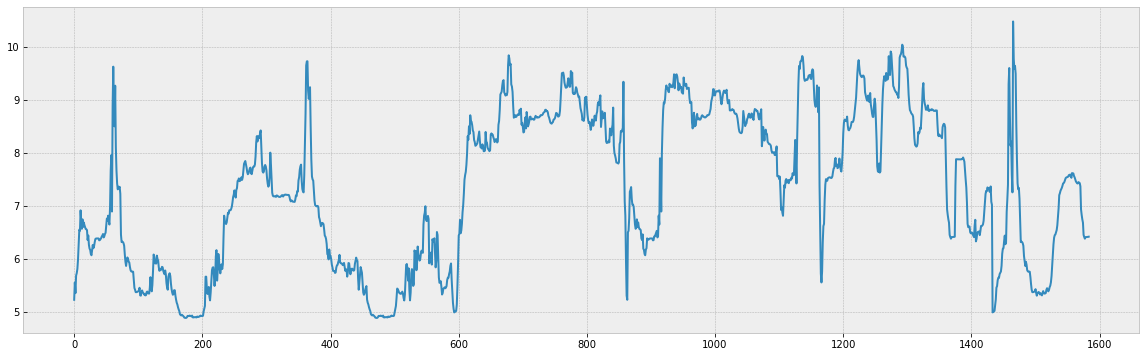

In [5]:
plt.plot(out_dtw[0])

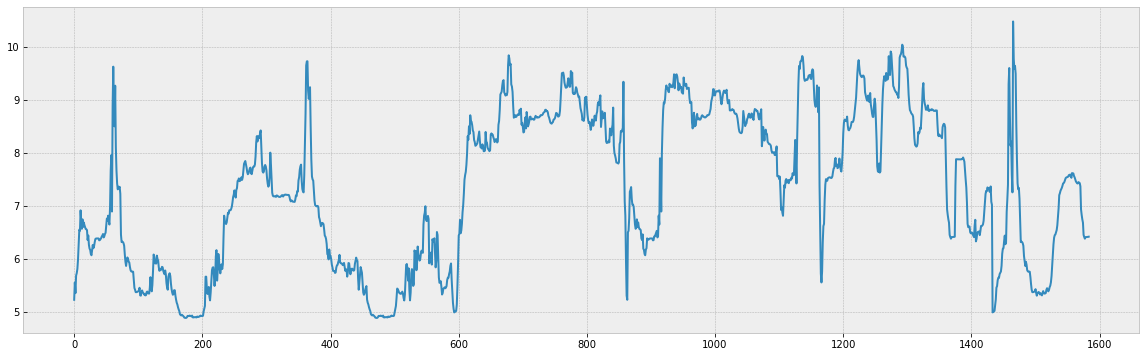

In [6]:
v = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius or maxwarp(paper)
out_dtw = stumpy.dtwMP(v, m, r)
plt.plot(out_dtw[0])

### 3.comparison with stump
Similar results were obtained, (Paper doesn't have exact number.)

In [9]:
out_stump = stumpy.stump(v, m)

Paper example, calculation of comparison

<img src="images_dtw/human_g.png" width="800">

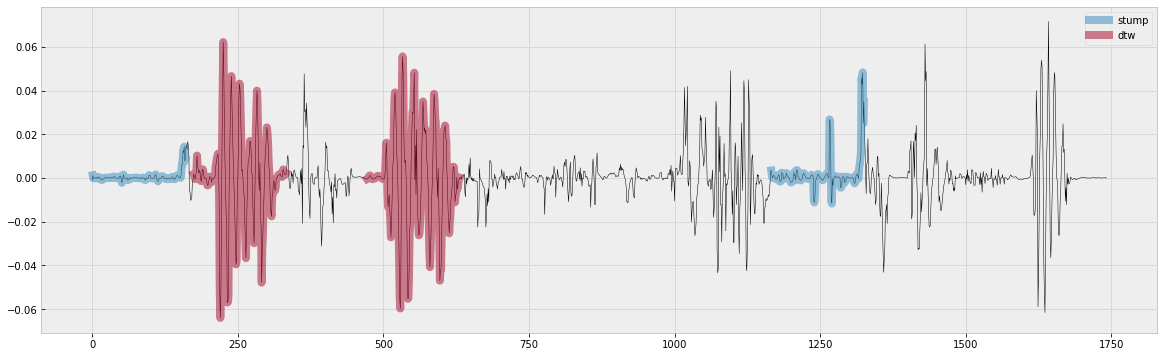

In [10]:
idx_a_dtw = np.argmin(out_dtw[0])
idx_b_dtw = out_dtw[1][idx_a_dtw]
idx_a_stump = np.argmin(out_stump[:,0])
idx_b_stump = out_stump[:,1][idx_a_stump]

x_ = np.arange(len(v))
plt.plot(v, color="k", linewidth=0.5)
plt.plot(x_[idx_a_stump:idx_a_stump+m],v[idx_a_stump:idx_a_stump+m], color="C0", alpha=0.5, linewidth=8, label="stump")
plt.plot(x_[idx_b_stump:idx_b_stump+m],v[idx_b_stump:idx_b_stump+m], color="C0", alpha=0.5, linewidth=8)
plt.plot(x_[idx_a_dtw:idx_a_dtw+m],v[idx_a_dtw:idx_a_dtw+m], color="C1", alpha=0.5, linewidth=8, label="dtw")
plt.plot(x_[idx_b_dtw:idx_b_dtw+m],v[idx_b_dtw:idx_b_dtw+m], color="C1", alpha=0.5, linewidth=8)
plt.legend()
plt.show()

### 4.Matrix profile and DTW MP

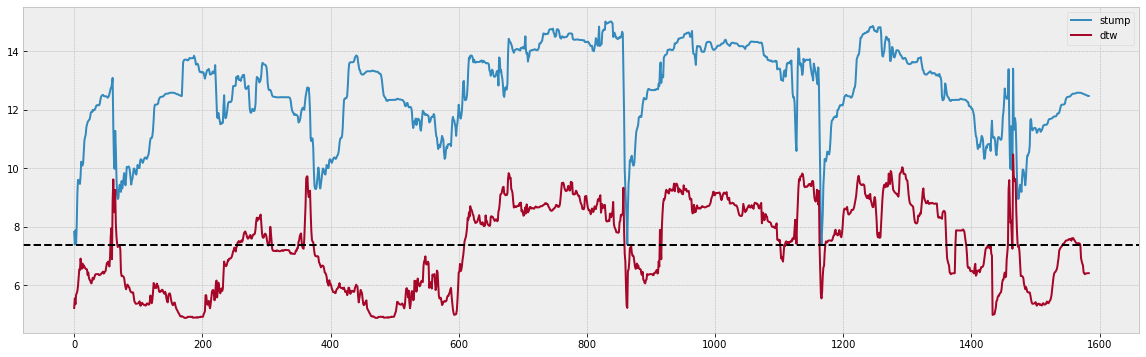

In [11]:
best_so_far = np.min(out_stump[:,0])  # swamp algo paramter

plt.plot(out_stump[:,0], label="stump")
plt.plot(out_dtw[0], label="dtw")
plt.axhline(best_so_far, color="k", linestyle="--")
plt.legend()
plt.show()

## DTW Masks List

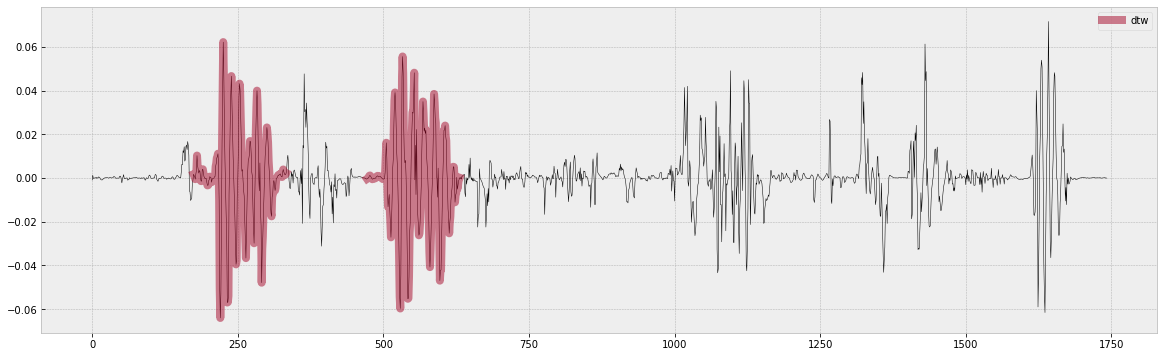

In [12]:
x_ = np.arange(len(v))
plt.plot(v, color="k", linewidth=0.5)
plt.plot(x_[idx_a_dtw:idx_a_dtw+m],v[idx_a_dtw:idx_a_dtw+m], color="C1", alpha=0.5, linewidth=8, label="dtw")
plt.plot(x_[idx_b_dtw:idx_b_dtw+m],v[idx_b_dtw:idx_b_dtw+m], color="C1", alpha=0.5, linewidth=8)
plt.legend()
plt.show()

### Itakura

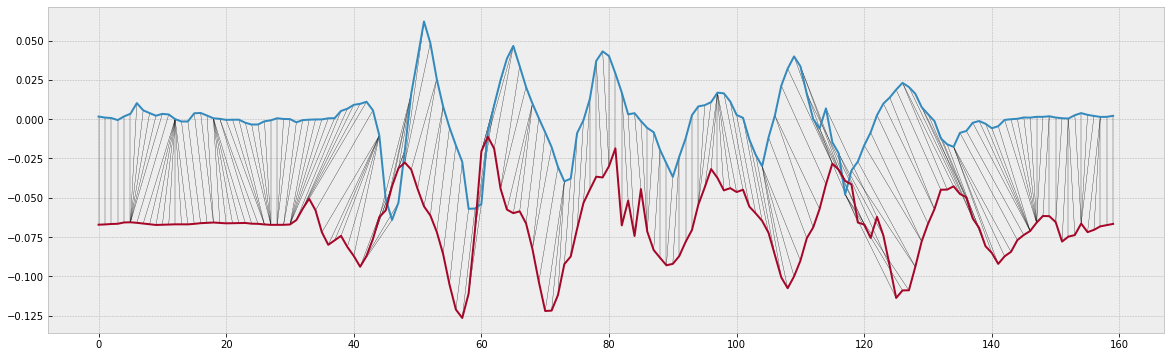

In [13]:
v_a, v_b = v[idx_a_dtw:idx_a_dtw+m], v[idx_b_dtw:idx_b_dtw+m]

path, sim = metrics.dtw_path(v_a, v_b, global_constraint="itakura", itakura_max_slope=2) # default setting(intendedly specified)
gap_plot = np.max(v_b)*1.2
x_path = np.asarray(path)
y_path = np.stack([v_a[x_path[:, 0]], v_b[x_path[:, 1]]-gap_plot]).T
for i in range(x_path.shape[0]):
    plt. plot(x_path[i, :], y_path[i, :], linewidth=0.3, color="k")
plt.plot(v_a)
plt.plot(v_b-gap_plot)
plt.show()

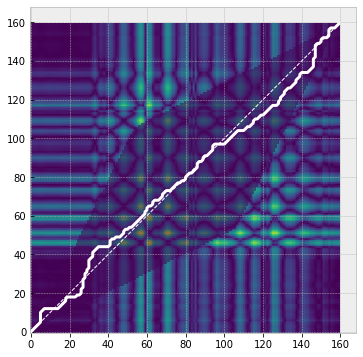

In [14]:
mat = cdist(v_a.reshape(-1, 1), v_b.reshape(-1, 1))
max_slope = 2
sz1 = len(v_a)
sz2 = len(v_b)
mask = metrics.itakura_mask(sz1, sz2, max_slope)

plt.figure(figsize=(6, 6))
plt.imshow(mat, origin='lower')
plt.imshow(mask, origin='lower', alpha=0.5)
plt.plot([j for (i, j) in path], [i for (i, j) in path], color="w" ,linewidth=3)
plt.plot([0, len(v_a)], [0, len(v_b)], color="w" ,linewidth=1, linestyle="--")
plt.show()

Greyscaled area is searched.  
White line is dtw calculation matching path.

### Sakoe-chiba

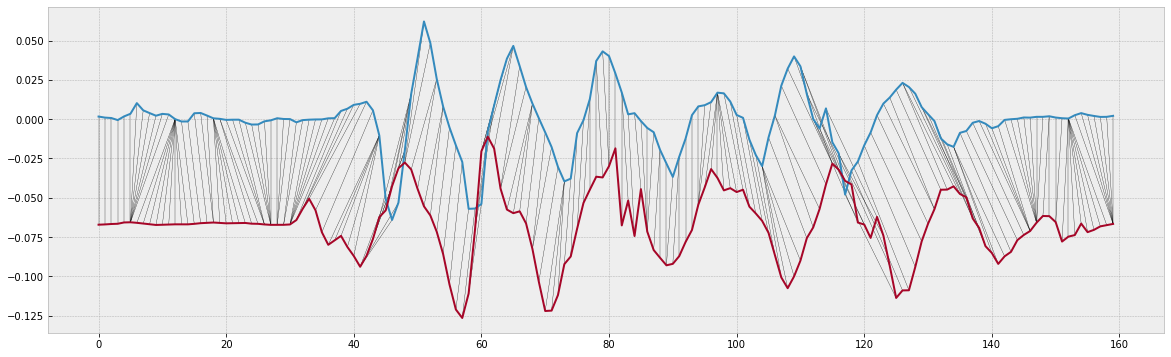

In [15]:
v_a, v_b = v[idx_a_dtw:idx_a_dtw+m], v[idx_b_dtw:idx_b_dtw+m]

path, sim = metrics.dtw_path(v_a, v_b, global_constraint="sakoe_chiba", sakoe_chiba_radius=r) # default setting(intendedly specified)
gap_plot = np.max(v_b)*1.2
x_path = np.asarray(path)
y_path = np.stack([v_a[x_path[:, 0]], v_b[x_path[:, 1]]-gap_plot]).T
for i in range(x_path.shape[0]):
    plt. plot(x_path[i, :], y_path[i, :], linewidth=0.3, color="k")
plt.plot(v_a)
plt.plot(v_b-gap_plot)
plt.show()

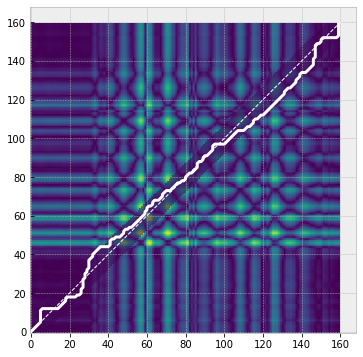

In [16]:
mat = cdist(v_a.reshape(-1, 1), v_b.reshape(-1, 1))
max_slope = 2
sz1 = len(v_a)
sz2 = len(v_b)
mask = metrics.sakoe_chiba_mask(sz1, sz2, r)

plt.figure(figsize=(6, 6))
plt.imshow(mat, origin='lower')
plt.imshow(mask, origin='lower', alpha=0.5)
plt.plot([j for (i, j) in path], [i for (i, j) in path], color="w" ,linewidth=3)
plt.plot([0, len(v_a)], [0, len(v_b)], color="w" ,linewidth=1, linestyle="--")
plt.show()

Greyscaled area is searched.  
White line is dtw calculation matching path.